### Linear regression base model:

In [13]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
#url = "../sourcedata/cleaned_data/7_data_transformation.csv"
url = "/workspaces/bakery_sales_prediction/sourcedata/cleaned_data/7_transformed_variables.csv"
umsatzdaten = pd.read_csv(url)

In [4]:
# Show dataset

# Extract column names as a list
columns = umsatzdaten.columns.tolist()

# Print the list of column names
print(columns)

umsatzdaten

['Datum', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'Warengruppe', 'Umsatz', 'Feiertage', 'Ferientage', 'Niederschlag', 'imp_mask_Bewoelkung', 'imp_mask_Temperatur', 'imp_mask_Windgeschwindigkeit', 'imp_mask_Niederschlag', 'imp_mask_Wettercode', 'Wetterklasse', 'temp_dv', 'year', 'month', 'weekday', 'day_month', 'season']


,Datum,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Warengruppe,Umsatz,Feiertage,Ferientage,...,imp_mask_Windgeschwindigkeit,imp_mask_Niederschlag,imp_mask_Wettercode,Wetterklasse,temp_dv,year,month,weekday,day_month,season
0,2013-07-01,6.0,17.8375,15.0,20.0,0.0,1.0,148.828353,0.0,1.0,...,0,0,0,6,-0.925000,2013,7,0,1,2
1,2013-07-01,6.0,17.8375,15.0,20.0,0.0,2.0,535.856285,0.0,1.0,...,0,0,0,6,-0.925000,2013,7,0,1,2
2,2013-07-01,6.0,17.8375,15.0,20.0,0.0,3.0,201.198426,0.0,1.0,...,0,0,0,6,-0.925000,2013,7,0,1,2
3,2013-07-01,6.0,17.8375,15.0,20.0,0.0,4.0,65.890169,0.0,1.0,...,0,0,0,6,-0.925000,2013,7,0,1,2
4,2013-07-01,6.0,17.8375,15.0,20.0,0.0,5.0,317.475875,0.0,1.0,...,0,0,0,6,-0.925000,2013,7,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,2018-07-31,5.0,31.2875,11.0,21.0,0.0,1.0,123.075682,0.0,1.0,...,0,0,1,6,6.655357,2018,7,1,31,2
9330,2018-07-31,5.0,31.2875,11.0,21.0,0.0,2.0,586.081666,0.0,1.0,...,0,0,1,6,5.733929,2018,7,1,31,2
9331,2018-07-31,5.0,31.2875,11.0,21.0,0.0,3.0,285.872616,0.0,1.0,...,0,0,1,6,4.812500,2018,7,1,31,2
9332,2018-07-31,5.0,31.2875,11.0,21.0,0.0,4.0,57.102795,0.0,1.0,...,0,0,1,6,3.850000,2018,7,1,31,2


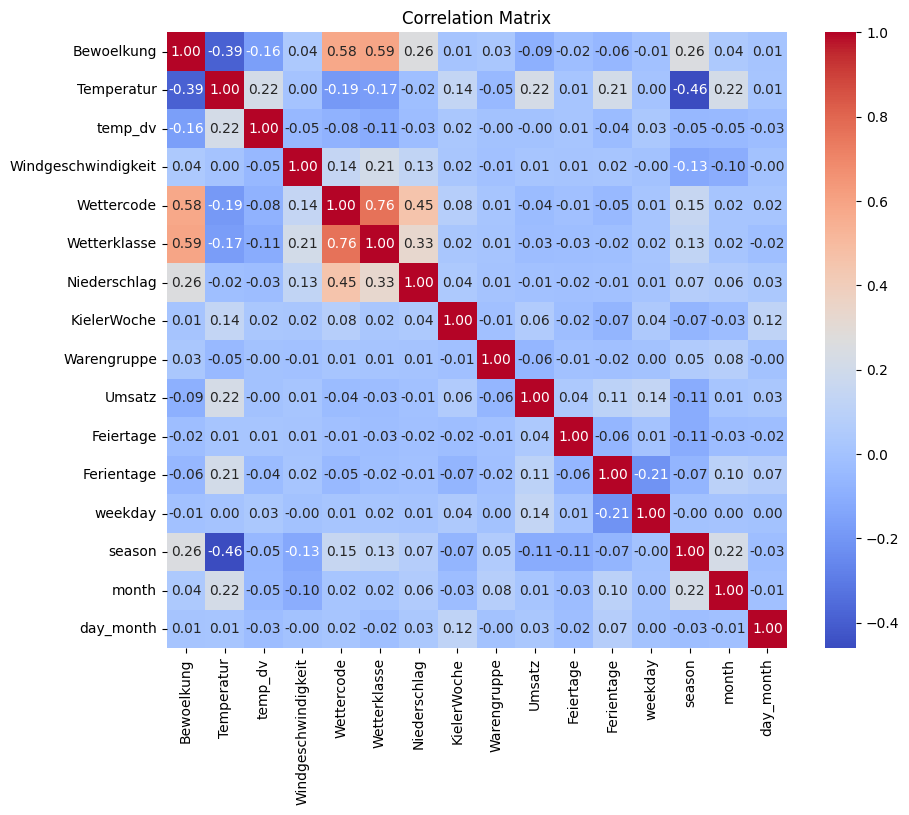

In [9]:
# Calculate correlation matrix
corr_matrix = umsatzdaten[['Bewoelkung', 'Temperatur', 'temp_dv', 'Windgeschwindigkeit', 'Wettercode', 'Wetterklasse', 'Niederschlag', 'KielerWoche', 'Warengruppe', 'Umsatz', 
                           'Feiertage', 'Ferientage', 'weekday', 'season', 'month', 'day_month']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))  # Adjust size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Notes from model improvement:


# R-sq: 0.686 # 'Umsatz ~ Temperatur * Niederschlag + C(Warengruppe)'
# R-sq: 0.686 # 'Umsatz ~ Temperatur * Bewoelkung + C(Warengruppe)'
# R-sq: 0.697 # 'Umsatz ~ Temperatur * Bewoelkung + C(Warengruppe) + C(season)'
# R-sq: 0.697 # 'Umsatz ~ Temperatur * Niederschlag + C(Warengruppe) + C(season)'
# R-sq: 0.698 # 'Umsatz ~ Temperatur * Niederschlag + C(Warengruppe) + C(season) + C(Wettercode)
# R-sq: 0.701 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode)+ C(Warengruppe) + C(season)'
# R-sq: 0.702 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode)+ C(Warengruppe) + C(season) + temp_dv'
# R-sq: 0.703 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode)+ C(Warengruppe) + C(season) + temp_dv + C(Ferientage)'
# R-sq: 0.705 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode)+ C(Warengruppe) + C(season) + temp_dv + C(Ferientage) + C(Feiertage)'
# R-sq: 0.705 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode)+ C(Warengruppe) + C(season) + temp_dv + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# R-sq: 0.706 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode)+ C(Warengruppe) + C(season) + temp_dv + C(Ferientage) + C(Feiertage) + C(KielerWoche) + Bewoelkung'
# R-sq: 0.709 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung + C(Warengruppe) + C(season) + temp_dv + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# R-sq: 0.717 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit + C(Warengruppe) + C(season) + temp_dv + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# R-sq: 0.717 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit * C(Wetterklasse)+ C(Warengruppe) + C(season) + temp_dv + C(Ferientage) + C(Feiertage) + C(KielerWoche)' 
# takes long long time with Wetterklasse!
# faster with + instead of * but no change in R-sq value. --> leave out!
# R-sq: 0.747 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit + C(Warengruppe) + C(season) + C(weekday) + temp_dv + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# R-sq: 0.781 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit + C(Warengruppe) * C(weekday) + C(season) + temp_dv + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# R-sq: 0.787 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit + C(Warengruppe) * C(weekday) + C(month) + C(season) + temp_dv + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# R-sq: 0.851 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit + C(Warengruppe) * C(weekday) * C(month) + C(season) + temp_dv + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# R-sq: 0.860 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit * temp_dv + C(Warengruppe) * C(weekday) * C(month) + C(season) + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# + C(season) or * makes no difference, but * takes way longer
# R-sq: 0.868 # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit * temp_dv + C(Warengruppe) * C(weekday) * C(month) + C(year) + C(season) + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# R-sq: 0.869 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit * temp_dv + C(Warengruppe) * C(weekday) * C(month) + C(day_month) + C(year) + C(season) + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# this makes the kernel crash...: 
# R-sq        # 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit * temp_dv + C(Warengruppe) * C(weekday) * C(month) * C(day_month) + C(year) + C(season) + C(Ferientage) + C(Feiertage) + C(KielerWoche)'
# R-sq:


### The model:

In [6]:
# The model with fine formula:

# Fit a new model with an interaction term between Temperatur and season
model = smf.ols('Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit * temp_dv + C(Warengruppe) * C(weekday) * C(month) + C(day_month) + C(year) + C(season) + C(Ferientage) + C(Feiertage) + C(KielerWoche)', data=umsatzdaten).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     54.82
Date:                Tue, 25 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:16:37   Log-Likelihood:                -50165.
No. Observations:                9334   AIC:                         1.024e+05
Df Residuals:                    8322   BIC:                         1.096e+05
Df Model:                        1011                                         
Covariance Type:            nonrobust                                         
                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

### Validation:

In [12]:
# Do a k-fold cross validation to check wether the model formula makes sencse or if we overfitted the model only trying to reach a high R-2

# Prepare formula
formula = 'Umsatz ~ Temperatur * Niederschlag * C(Wettercode) * Bewoelkung * Windgeschwindigkeit * temp_dv + C(Warengruppe) * C(weekday) * C(month) + C(day_month) + C(year) + C(season) + C(Ferientage) + C(Feiertage) + C(KielerWoche)'

# Prepare data
X = umsatzdaten.drop(columns=['Umsatz', 'Datum'])
y = umsatzdaten['Umsatz']

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize list to hold R-squared values
r_squared_values = []

# Perform manual cross-validation
for train_index, test_index in kf.split(X):
    train_data = umsatzdaten.iloc[train_index]
    test_data = umsatzdaten.iloc[test_index]
    
    # Fit the model on the training data
    model = smf.ols(formula, data=train_data).fit()
    
    # Predict on the test data
    predictions = model.predict(test_data)
    
    # Calculate R-squared for the test data
    ss_res = np.sum((test_data['Umsatz'] - predictions) ** 2)
    ss_tot = np.sum((test_data['Umsatz'] - np.mean(train_data['Umsatz'])) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared_values.append(r_squared)

# Print the cross-validation scores
print(f"Cross-Validation R-squared Scores: {r_squared_values}")
print(f"Mean Cross-Validation R-squared: {np.mean(r_squared_values)}")

Cross-Validation R-squared Scores: [0.7831129910709567, 0.8690670919135706, 0.856027214024433, 0.7263895318087165, 0.8454007611017007]
Mean Cross-Validation R-squared: 0.8159995179838754


In [11]:
# This is a cross validation without defining further input. This does not help but shows how bad the model would perform if we donot adjust the formula:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

X = umsatzdaten.drop(columns=['Umsatz', 'Datum'])
y = umsatzdaten['Umsatz']
lm = LinearRegression()
scores = cross_val_score(lm, X, y, cv=5)
print(f"Cross-Validation Scores: {scores}")
print(f"Mean CV Score: {np.mean(scores)}")

Cross-Validation Scores: [0.09130302 0.04494211 0.09877441 0.10792874 0.05940137]
Mean CV Score: 0.08046992900745362


In [8]:
# just a check if the data is ok and no missing values are left
df = umsatzdaten.copy()
print("Missing values in each column:")
print(df.isna().sum())

Missing values in each column:
Datum                           0
Bewoelkung                      0
Temperatur                      0
Windgeschwindigkeit             0
Wettercode                      0
KielerWoche                     0
Warengruppe                     0
Umsatz                          0
Feiertage                       0
Ferientage                      0
Niederschlag                    0
imp_mask_Bewoelkung             0
imp_mask_Temperatur             0
imp_mask_Windgeschwindigkeit    0
imp_mask_Niederschlag           0
imp_mask_Wettercode             0
Wetterklasse                    0
temp_dv                         0
year                            0
month                           0
weekday                         0
day_month                       0
season                          0
dtype: int64


In [5]:
# save the summary to a text file
with open('./results/linear_regression_summary.txt', 'w') as f:
    f.write(str(model.summary()))

# save the model
model.save('./results/linear_regression.pickle')
